In [432]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import imutils

In [433]:
def draw_rect(img, rect):
    return cv2.rectangle(img, (int(rect[0]), int(rect[1])), \
              (int(rect[0]+rect[2]), int(rect[1]+rect[3])), (90,255,0), 2)

In [434]:
konf_path = Path("../photos/cards-konf")
# konf_path = Path("../photos/j1")
img_paths = [path for path in konf_path.iterdir()]

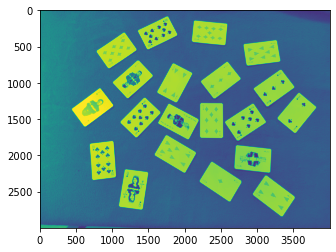

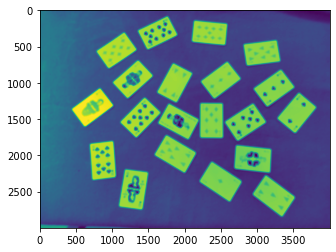

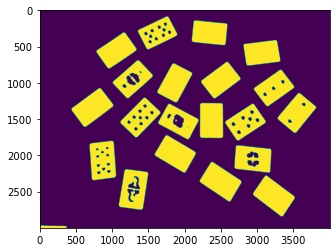

In [435]:
img = cv2.imread(str(img_paths[8]))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)[:,:,2]
plt.imshow(gray)
plt.show()
blur = cv2.GaussianBlur(gray,(33,33),10,10)
plt.imshow(blur)
plt.show()

thresh_level = 100

retval, thresh = cv2.threshold(blur,thresh_level,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresh)

cnts,hier = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
index_sort = sorted(range(len(cnts)), key=lambda i : cv2.contourArea(cnts[i]),reverse=True)

cnts_sort = []
hier_sort = []
cnt_is_card = np.zeros(len(cnts),dtype=int)

for i in index_sort:
        cnts_sort.append(cnts[i])
        hier_sort.append(hier[0][i])

for i in range(len(cnts_sort)):
    size = cv2.contourArea(cnts_sort[i])
    peri = cv2.arcLength(cnts_sort[i],True)
    approx = cv2.approxPolyDP(cnts_sort[i],0.01*peri,True)

    if ((size < 100000000) and (size > 30)
        and (hier_sort[i][3] == -1) and (len(approx) in [4,56,7,8])):
        cnt_is_card[i] = 1

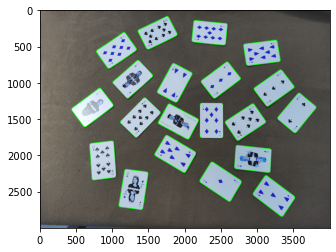

In [436]:
for card, is_card in zip(cnts_sort,cnt_is_card):
    if(is_card):
        cv2.drawContours(img, card, -1, (0, 255, 0), 10)
        
plt.imshow(img)

In [437]:
def scale_contour(cnt, scale):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

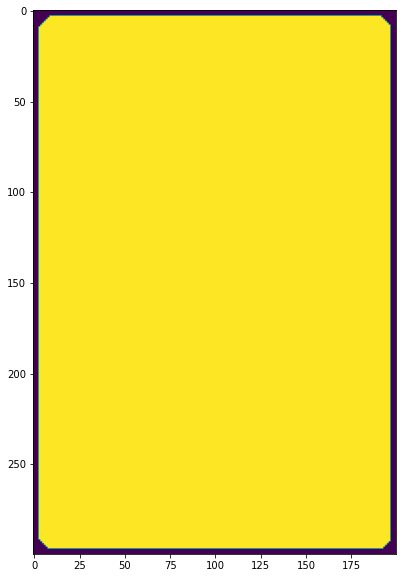

In [438]:
bord_size=3 # bord_size alpha=0
alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255
cv2.rectangle(alphamask,(0,0),(cardW-1,cardH-1),0,bord_size)
cv2.line(alphamask,(bord_size*3,0),(0,bord_size*3),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,0),(cardW,bord_size*3),0,bord_size)
cv2.line(alphamask,(0,cardH-bord_size*3),(bord_size*3,cardH),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,cardH),(cardW,cardH-bord_size*3),0,bord_size)
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

In [439]:
def straighten_card(image, pts, w, h):
    temp_rect = np.zeros((4,2), dtype = "float32")
    
    s = np.sum(pts, axis = 2)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]

    diff = np.diff(pts, axis = -1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    # Need to create an array listing points in order of
    # [top left, top right, bottom right, bottom left]
    # before doing the perspective transform

    if w <= 0.8*h: # If card is vertically oriented
        temp_rect[0] = tl
        temp_rect[1] = tr
        temp_rect[2] = br
        temp_rect[3] = bl

    if w >= 1.2*h: # If card is horizontally oriented
        temp_rect[0] = bl
        temp_rect[1] = tl
        temp_rect[2] = tr
        temp_rect[3] = br

    # If the card is 'diamond' oriented, a different algorithm
    # has to be used to identify which point is top left, top right
    # bottom left, and bottom right.
    
    if w > 0.8*h and w < 1.2*h: #If card is diamond oriented
        # If furthest left point is higher than furthest right point,
        # card is tilted to the left.
        if pts[1][0][1] <= pts[3][0][1]:
            # If card is titled to the left, approxPolyDP returns points
            # in this order: top right, top left, bottom left, bottom right
            temp_rect[0] = pts[1][0] # Top left
            temp_rect[1] = pts[0][0] # Top right
            temp_rect[2] = pts[3][0] # Bottom right
            temp_rect[3] = pts[2][0] # Bottom left

        # If furthest left point is lower than furthest right point,
        # card is tilted to the right
        if pts[1][0][1] > pts[3][0][1]:
            # If card is titled to the right, approxPolyDP returns points
            # in this order: top left, bottom left, bottom right, top right
            temp_rect[0] = pts[0][0] # Top left
            temp_rect[1] = pts[3][0] # Top right
            temp_rect[2] = pts[2][0] # Bottom right
            temp_rect[3] = pts[1][0] # Bottom left
            
        
    maxWidth = 200
    maxHeight = 300
    
    
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
#     cv2.drawContours(img, temp_rect,-1, (255, 0, 0), 10)
    M = cv2.getPerspectiveTransform(temp_rect,dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
#     warp = cv2.cvtColor(warp,cv2.COLOR_BGR2GRAY)

        

    return warp

def detect_cards(img, debug = False):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(33,33),10,10)
    thresh_level = 100

    retval, thresh = cv2.threshold(blur,thresh_level,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    cnts,hier = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    index_sort = sorted(range(len(cnts)), key=lambda i : cv2.contourArea(cnts[i]),reverse=True)

    cnts_sort = []
    hier_sort = []

    for i in index_sort:
        cnts_sort.append(cnts[i])
        hier_sort.append(hier[0][i])

    cards = []
    corners = []
    for i in range(len(cnts_sort)):
        size = cv2.contourArea(cnts_sort[i])
        peri = cv2.arcLength(cnts_sort[i],True)
        approx = cv2.approxPolyDP(cnts_sort[i],0.01*peri,True)
        if ((size < 20000000) and (size > 30) and (hier_sort[i][3] == -1) and (len(approx) in [4,5,6,7,8])):
            cont = scale_contour(cnts[i], 1.03)
            cards.append(cont)
            corners.append(cv2.approxPolyDP(cont,0.01*peri,True))
    ready_cards = []
    for card, corn in zip(cards,corners):
        x,y,w,h = cv2.boundingRect(corn)
        straightened_card = straighten_card(img,corn,w,h)
        straightened_card = cv2.cvtColor(straightened_card,cv2.COLOR_BGR2BGRA)
        straightened_card[:,:,3]=alphamask
        first_box = findBox(straightened_card, refCornerHL, name="Top",debug=debug)
        second_box = findBox(straightened_card, refCornerLR, name="Bottom",debug=debug)
        if debug:
            cv2.imshow("carde", straightened_card)
            mid_point = np.sum(corn, axis = 0)/corn.shape[0]
            mid_point = mid_point[0].astype(np.int32)
            cv2.drawContours(img, card, -1, (0, 255, 0), 10)
            img = cv2.circle(img, (mid_point[0],mid_point[1]), radius=10, color=(0, 0, 255), thickness=-1)
            cv2.imshow('video', cv2.resize(img,(450,800)))
        ready_cards.append((straightened_card,first_box,second_box))
    return ready_cards

## VIDEO

In [440]:
# video = cv2.VideoCapture(str(Path('../photos/cards-konf/VID_20211228_164418.mp4')))
# # video = cv2.VideoCapture(str(Path('../photos/j1/VID_20211229_170039.mp4')))
# wrong_image = None
# while True:
#     if video.grab():
#         flag, frame = video.retrieve()
#         if not flag:
#             continue
#         else:
#             cv2.imshow('video', cv2.resize(detect_cards(frame.copy()),(450,800)))
#     if cv2.waitKey(10) == 27:
#         break
#     if cv2.waitKey(10) == 32:
#         wrong_image = frame

In [441]:
cardW=200
cardH=300
cornerXmin=1
cornerXmax=9.5
cornerYmin=2
cornerYmax=23.5


zoom=3.5
# cardW*=zoom
# cardH*=zoom
cornerXmin=int(cornerXmin*zoom)
cornerXmax=int(cornerXmax*zoom)
cornerYmin=int(cornerYmin*zoom)
cornerYmax=int(cornerYmax*zoom)

In [442]:
refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
refCorners=np.array([refCornerHL,refCornerLR])

In [443]:

def findBox(img,corner, name = "Top", debug=False):
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
#     kernel = np.ones((5,5),np.uint8)
    corner=corner.astype(np.int)

    # We will focus on the zone of 'img' delimited by 'corner'
    x1=int(corner[0][0])
    y1=int(corner[0][1])
    x2=int(corner[2][0])
    y2=int(corner[2][1])
    w=x2-x1
    h=y2-y1
    zone=img[y1:y2,x1:x2].copy()

    strange_cnt=np.zeros_like(zone)
    gray=cv2.cvtColor(zone,cv2.COLOR_BGR2GRAY)
    thld=cv2.Canny(gray,30,200)
    cv2.imshow("canny", thld)
    thld = cv2.dilate(thld,kernel,iterations=1)
    if debug: cv2.imshow("thld",thld)
    
    # Find the contours
    contours, _=cv2.findContours(thld.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    min_area=5 # We will reject contours with small area. TWEAK, 'zoom' dependant
    min_solidity=0.3 # Reject contours with a low solidity. TWEAK
    
    concat_contour=None # We will aggregate in 'concat_contour' the contours that we want to keep
    
    ok=True
    for c in contours:
        area=cv2.contourArea(c)

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        # Determine the center of gravity (cx,cy) of the contour
        M=cv2.moments(c)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        #  abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 : TWEAK, the idea here is to keep only the contours which are closed to the center of the zone
        if area >= min_area and abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 and solidity>min_solidity:
            if debug :
                cv2.drawContours(zone,[c],0,(255,0,0),-1)
            if concat_contour is None:
                concat_contour=c
            else:
                concat_contour=np.concatenate((concat_contour,c))
    
    if concat_contour is not None:
#         concat_contour = scale_contour(concat_contour, 1)
        concat_contour_in_image = concat_contour + corner[0]
        rect = cv2.boundingRect(concat_contour)
        
        pad = 5
        rect_in_image = list(cv2.boundingRect(concat_contour_in_image)) 
        rect_in_image[0] = max(rect_in_image[0] - pad,0)
        rect_in_image[1] = max(rect_in_image[1] - pad,0)
        rect_in_image[2] = min(rect_in_image[0] + rect_in_image[2] + 2*pad, img.shape[1])
        rect_in_image[3] = min(rect_in_image[1] + rect_in_image[3] + 2*pad,img.shape[0])
                             
        if debug:
            cv2.rectangle(zone, (int(rect[0]), int(rect[1])), (int(rect[2]), int(rect[3])), (90,255,0), 2)
            cv2.rectangle(img, (int(rect_in_image[0]), int(rect_in_image[1])), \
              (int(rect_in_image[2]), int(rect_in_image[3])), (90,255,0), 2)
            cv2.imshow("Zone"+name,zone)
            cv2.imshow("Image",img)
                             
        return rect_in_image
    return None

In [444]:
pths = ["../photos/Janek-2/1640860827836.jpg", "../photos/Janek-2/1640860827853.jpg", "../photos/Janek-2/1640860827869.jpg", "../photos/Janek-2/1640860872241.jpg", "../photos/Janek-2/1640860872255.jpg"]
detection = detect_cards(cv2.imread(pths[1]), debug=True)
cv2.waitKey(10)
len(detection)
detection[0][0].shape

(300, 200, 4)

In [445]:
boxes = {}
for i,path in enumerate([p for p in Path("../photos/52-deck").iterdir()]):
    card,first_box, second_box = detect_cards(cv2.imread(str(path)), debug=False)[0]
    add = [
        [(box[0],box[1]),(box[2],box[1]),(box[0],box[3]),(box[2],box[3])] 
        for box in [first_box,second_box]
    ]
    boxes[path.stem] = add
#     for card,first_box, second_box in detection:
#     cv2.imshow("Image", card)
#     cv2.waitKey(0)
    
#     cv2.imwrite(f"{path.stem}.png", card)

boxes

{'C9': [[(7, 9), (38, 9), (7, 78), (38, 78)],
  [(162, 217), (193, 217), (162, 287), (193, 287)]],
 'CA': [[(6, 9), (37, 9), (6, 78), (37, 78)],
  [(162, 218), (194, 218), (162, 287), (194, 287)]],
 'CQ': [[(8, 10), (38, 10), (8, 79), (38, 79)],
  [(162, 219), (192, 219), (162, 289), (192, 289)]],
 'C4': [[(6, 10), (37, 10), (6, 79), (37, 79)],
  [(162, 218), (192, 218), (162, 287), (192, 287)]],
 'D5': [[(8, 16), (37, 16), (8, 87), (37, 87)],
  [(164, 213), (194, 213), (164, 283), (194, 283)]],
 'H8': [[(3, 17), (34, 17), (3, 85), (34, 85)],
  [(164, 214), (195, 214), (164, 283), (195, 283)]],
 'HJ': [[(5, 8), (36, 8), (5, 77), (36, 77)],
  [(162, 222), (192, 222), (162, 289), (192, 289)]],
 'DK': [[(6, 14), (37, 14), (6, 87), (37, 87)],
  [(163, 213), (194, 213), (163, 285), (194, 285)]],
 'D8': [[(7, 15), (38, 15), (7, 86), (38, 86)],
  [(164, 215), (195, 215), (164, 286), (195, 286)]],
 'D9': [[(6, 10), (35, 10), (6, 81), (35, 81)],
  [(163, 217), (192, 217), (163, 288), (192, 288)

In [430]:
content = json.dumps(boxes)
Path("boxes.json").write_text(content)

5094

In [227]:
cv2.imwrite("card.jpg", detection[0][0])

True

In [228]:
detection[0][1:]

([1, 7, 32, 84], [167, 215, 198, 292])